In [27]:
import uproot
import awkward as ak #The events object is an awkward array
## Plotting.
import matplotlib.pyplot as plt

# Hists
import hist
from hist import Hist

# NanoEvents
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

# Processors
#import coffea.processor as processor
from coffea import processor

#Math
import math

#Numpy
import numpy as np

#PackedSelection to select events
from coffea.analysis_tools import PackedSelection

In [45]:
# The processor class bundles our data analysis together while giving us some helpful tools.  It also leaves looping and chunks to the framework instead of us.
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass
    
    def process(self, old_events):
        #Implement the selections to veto events
        selection = PackedSelection()
        #At least one lepton 
        selection.add("one_l", (ak.num(old_events.Electron)+ak.num(old_events.Muon))>=1)
        
        #Electron signal region
        selection.add("fst_tight_e", ak.mask(old_events.Electron, ak.num(old_events.Electron) >= 1)[:, 0].mvaFall17V2Iso_WP90 == True)
        selection.add(
            "electron_pt",
            ak.any(old_events.Electron.pt > 35.0, axis=1)  
        )
        selection.add(
            "e_range_eta",
            ak.any(abs (old_events.Electron.eta) < 2.5, axis=1)
        )
        #The following two cuts work in inverse logic, when you require the selection later you must take false
        selection.add("snd_tight_e", ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WP90 == True)
        selection.add("loose_e", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WPL == True) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].pt >10))
        
        #Muon signal region (boosted)
        selection.add("one_tight_mu", ak.mask(old_events.Muon, ak.num(old_events.Muon) >= 1)[:, 0].tightId == (3>2))
        selection.add("no_2nd_tight_mu", ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].tightId == (3==2))
        #The following three cuts work in inverse logic, when you require the selection later you must take false
        selection.add("any_tight_e", ak.any(old_events.Electron.mvaFall17V2Iso_WP90 == (3>2), axis=1))
        selection.add(
            "muon_Pt",
            ak.any(old_events.Muon.pt >= 30.0, axis=1)
        )
        selection.add(
            "mu_range_eta",
            ak.any(abs (old_events.Muon.eta) < 2.4, axis=1)
        )
        selection.add("loose_mu", (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].looseId == (3>2)) & (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].pt >10))
        selection.add("loose_e1", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 0].mvaFall17V2Iso_WPL == (3>2)) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 0].pt >10))
        selection.add("loose_e2", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WPL == (3>2)) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].pt >10))
        
        #Puppy met cut
        selection.add("lead_pMET", old_events.PuppiMET.pt>30)
        #b Veto
        selection.add("b_veto", ak.all(old_events.Jet.btagDeepB<=0.84, axis=1))
        #selection.add("b_veto", ak.all(old_events.Jet.btagCSVV2<=0.81, axis=1))
        #VBS jets (looking for the max invariant mass pair)
        # Get all combinations of jet pairs in every event
        dijets = ak.combinations(old_events.Jet, 2, fields=['i0', 'i1'])
        # Check that jet pairs have the greatest mass
        ismax=(dijets['i0']+dijets['i1']).mass==ak.max((dijets['i0']+dijets['i1']).mass, axis=1)
        #previous line: returns a Boolean array with True where the condition is met, and false otherwise
        # Mask the dijets with the ismax to get dijets with the gratest mass
        VBS_jets = dijets[ismax]
        # Separate pairs into arrays of the leading and the trailing VBS jets in each pair.
        VBS_jet_l, VBS_jet_t = ak.unzip(VBS_jets)
        #VBS selection
        selection.add(
            "lead_VBS_ljet",   
            ak.all(VBS_jet_l.pt>50, axis=1)
        )
        selection.add(
            "lead_VBS_tjet",   
            ak.all(VBS_jet_t.pt>30, axis=1)
        )
        selection.add(
            "lead_VBS_mass",   
            ak.all((VBS_jet_l+VBS_jet_t).mass>500, axis=1)
        )
        selection.add(
            "lead_VBS_eta",   
            ak.all(abs(VBS_jet_l.eta-VBS_jet_t.eta)>2.5, axis=1)
        )
        selection.add("one_fatjet", (ak.num(old_events.FatJet) == 1))
        selection.add("two_jet", (ak.num(old_events.Jet) >= 2))
        #Transverse mass of the W boson decaying leptonically
        #With electrons
        selection.add(
            "W_Tmass_e",
            ak.all(2*old_events.Electron.pt*old_events.MET.pt*(1-np.cos(old_events.Electron.phi-old_events.MET.phi))<185**2, axis=1)
        )
        #With muons
        selection.add(
            "W_Tmass_mu",
            ak.all(2*old_events.Muon.pt*old_events.MET.pt*(1-np.cos(old_events.Muon.phi-old_events.MET.phi))<185**2, axis=1)
        )
        #Invariant mass of the W boson decaying hadronically, use softdropmass
        selection.add(
            "W_mass_fatjet",
            ak.all((old_events.FatJet.msoftdrop>70) & (old_events.FatJet.msoftdrop<115), axis=1)
        )
        
        #Electron mask
        #one_l=True, fst_tight_e=True, snd_tight_e=False, loose_e=False, electron_pt=True, e_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, one_fatjet=True, two_jet=True, W_Tmass_e=True, W_mass_fatjet=True
        ev_mask_e = selection.require(one_l=True, fst_tight_e=True, snd_tight_e=False, loose_e=False, electron_pt=True, e_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, two_jet=True, one_fatjet=True, W_mass_fatjet=True)
        #Muon mask
        ev_mask_mu = selection.require(one_l=True, one_tight_mu=True, no_2nd_tight_mu=True, loose_mu=False, loose_e1=False, loose_e2=False, any_tight_e=False, muon_Pt=True, mu_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, one_fatjet=True, two_jet=True, W_Tmass_mu=True, W_mass_fatjet=True)
        #Apply the cuts on the events with the mask (chose either electron or muon signal region)
        events=old_events[ev_mask_e]
        
        # This is where we do our actual analysis. The dataset has columns similar to the TTree's; events.columns can tell you them, or events.[object].columns for deeper depth.
        dataset = events.metadata['dataset']
        #Define the fiducial region
        #Electron, muon , jets, fatjets
        electron = events.Electron
        muon = events.Muon
        jets=events.Jet
        fatjets = events.FatJet
        #Jets isolation from electrons
        # Get all combinations of jets and electrons in every event
        jets_e = ak.cartesian({"x": jets, "y": electron})
        # Check that jets satisfy the isolation
        jets_iso_e = ((jets_e["x"].eta-jets_e["y"].eta)**2+(jets_e["x"].phi-jets_e["y"].phi)**2>0.4**2)
        # Mask the jets_e with the jets_iso to get jets isolated from electrons
        jets_e = jets_e[jets_iso_e]
        # Separate pairs into jets and electons, redefining the jets (but not the electrons)
        jets, el = ak.unzip(jets_e)
        #FatJets isolation from electrons
        # Get all combinations of fatjets and electrons in every event
        fatjets_e = ak.cartesian({"x": fatjets, "y": electron})
        # Check that jets satisfy the isolation
        fatjets_iso_e = ((fatjets_e["x"].eta-fatjets_e["y"].eta)**2+(fatjets_e["x"].phi-fatjets_e["y"].phi)**2>0.8**2)
        # Mask the fatjets_e with the fatjets_iso to get fatjets isolated from electrons
        fatjets_e = fatjets_e[fatjets_iso_e]
        # Separate pairs into fatjets and electons, redefining the fatjets (but not the electrons)
        fatjets, el = ak.unzip(fatjets_e)
        #Jets isolation from muons
        # Get all combinations of jets and muons in every event
        #jets_mu = ak.cartesian({"x": jets, "y": muon})
        # Check that jets satisfy the isolation
        #jets_iso_mu = ((jets_mu["x"].eta-jets_mu["y"].eta)**2+(jets_mu["x"].phi-jets_mu["y"].phi)**2>0.4**2)
        # Mask the jets_mu with the jets_iso_mu to get jets isolated from muons
        #jets_mu = jets_mu[jets_iso_mu]
        # Separate pairs into jets and muons, redefining the jets (but not the muons)
        #jets, mu = ak.unzip(jets_mu)
        #FatJets isolation from muons
        # Get all combinations of fatjets and muons in every event
        #fatjets_mu = ak.cartesian({"x": fatjets, "y": muon})
        # Check that fatjets satisfy the isolation
        #fatjets_iso_mu = ((fatjets_mu["x"].eta-fatjets_mu["y"].eta)**2+(fatjets_mu["x"].phi-fatjets_mu["y"].phi)**2>0.8**2)
        # Mask the fatjets_mu with the fatjets_iso_mu to get fatjets isolated from muons
        #fatjets_mu = fatjets_mu[fatjets_iso_mu]
        # Separate pairs into jets and muons, redefining the jets (but not the muons)
        #fatjets, mu = ak.unzip(fatjets_mu)
        #Jets cuts
        jets_eta_cut = (abs (jets.eta) < 4.7)
        jets_pt_cut = (jets.pt > 30)
        jets = jets[jets_pt_cut&jets_eta_cut]
        #FatJets cuts
        fatjets_eta_cut = (abs (fatjets.eta) < 2.4)
        fatjets_pt_cut = (fatjets.pt > 200)
        fatjets = fatjets[fatjets_pt_cut&fatjets_eta_cut]
        #Removing AK4(Jet) jets overlapping with AK8(FatJets) jets
        # Get all combinations of jets and fatjets in every event
        jets_fatjets = ak.cartesian({"x": jets, "y": fatjets})
        # Check that jets satisfy the isolation
        jets_iso_f = ((jets_fatjets["x"].eta-jets_fatjets["y"].eta)**2+(jets_fatjets["x"].phi-jets_fatjets["y"].phi)**2>0.8**2)
        # Mask the jets_fatjets with the jets_iso_f to get jets isolated from fatjets
        jets_fatjets = jets_fatjets[jets_iso_f]
        # Separate pairs into jets and electons, redefining the jets (but not the fatjets)
        jets, fj = ak.unzip(jets_fatjets)
        
        # Bins and categories for the histogram
        h_MET = hist.Hist(hist.axis.StrCategory(name='channel', categories=['MET']), 
                      hist.axis.Regular(name='x', label='$E_{T}^{miss}$ [GeV]', bins=12, start=30, stop=400))
        h_e_pT = hist.Hist(hist.axis.StrCategory(name='channel', categories=['e_pT']), 
                      hist.axis.Regular(name='x', label='$p_{T}^{e}$ [GeV]', bins=8, start=35, stop=150))
        h_fatjet = hist.Hist(hist.axis.StrCategory(name='channel', categories=['fatjet']), 
                      hist.axis.Regular(name='x', label='$p_{T}^{e}$ [GeV]', bins=20, start=30, stop=150))

        # This fills our histogram once our data is collected.
        h_MET.fill(channel='MET', x=events.MET.pt)
        h_e_pT.fill(channel='e_pT', x=events.Electron[:,0].pt)
        h_fatjet.fill(channel='fatjet', x=ak.flatten(events.FatJet.mass))
        #previous line: you have to flatten the awkward array because its size is ambiguous due to variable-length arrays
        return {
            dataset: {
                "entries": len(events),
                "MET": h_MET,
                "e_pT": h_e_pT,
                "fatjet": h_fatjet,
            }
        }
    
    def postprocess(self, accumulator):
        pass

In [46]:
base = '/eos/cms/store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/'

fileset = {
    'bkg': [
        base + '2810000/8D99B98F-CABA-E74E-81E3-63779BC0A6AD.root',
        base + '30000/08A5C166-FD81-954D-B937-923B4A1C085C.root',
    ],
    'signal': [
        'com_SM_final.root'
    ]
}

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=4),
    schema=NanoAODSchema,
    #maxchunks=5,
)

out = futures_run(
    fileset,
    "Events",
    processor_instance=MyProcessor()
)
out

Processing:   0%|          | 0/21 [00:00<?, ?chunk/s]

{'signal': {'MET': Hist(
    StrCategory(['MET'], name='channel'),
    Regular(12, 30, 400, name='x', label='$E_{T}^{miss}$ [GeV]'),
    storage=Double()) # Sum: 1677.0 (1845.0 with flow),
  'entries': 1845,
  'e_pT': Hist(
    StrCategory(['e_pT'], name='channel'),
    Regular(8, 35, 150, name='x', label='$p_{T}^{e}$ [GeV]'),
    storage=Double()) # Sum: 1827.0 (1845.0 with flow),
  'fatjet': Hist(
    StrCategory(['fatjet'], name='channel'),
    Regular(20, 30, 150, name='x', label='$p_{T}^{e}$ [GeV]'),
    storage=Double()) # Sum: 0.0 (1845.0 with flow)},
 'bkg': {'entries': 5,
  'MET': Hist(
    StrCategory(['MET'], name='channel'),
    Regular(12, 30, 400, name='x', label='$E_{T}^{miss}$ [GeV]'),
    storage=Double()) # Sum: 5.0,
  'e_pT': Hist(
    StrCategory(['e_pT'], name='channel'),
    Regular(8, 35, 150, name='x', label='$p_{T}^{e}$ [GeV]'),
    storage=Double()) # Sum: 5.0,
  'fatjet': Hist(
    StrCategory(['fatjet'], name='channel'),
    Regular(20, 30, 150, name='x', la

1845


Text(0.5, 1.0, 'MET distribution')

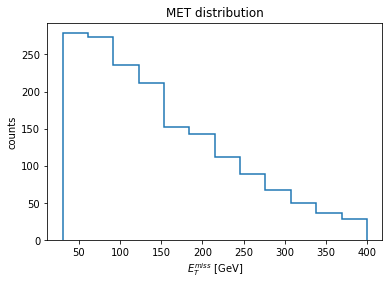

In [47]:
print(out["signal"]["entries"])
out["signal"]["MET"].plot()
plt.xlabel("$E_{T}^{miss}$ [GeV]")
plt.ylabel("counts")
plt.title("MET distribution")

Text(0.5, 1.0, 'electron $p_{T}$ distribution')

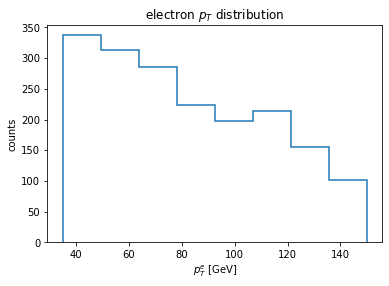

In [48]:
out["signal"]["e_pT"].plot()
plt.xlabel("$p_{T}^{e}$ [GeV]")
plt.ylabel("counts")
plt.title("electron $p_{T}$ distribution")

Text(0.5, 1.0, 'AK8 jet distribution')

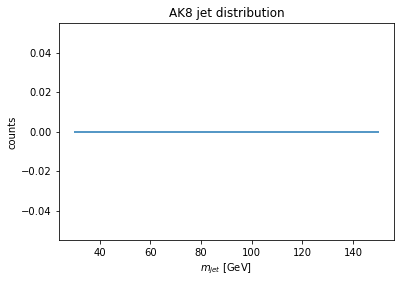

In [49]:
out["signal"]["fatjet"].plot()
plt.xlabel("$m_{jet}$ [GeV]")
plt.ylabel("counts")
plt.title("AK8 jet distribution")

In [55]:
#Check
print(ak.num(old_events.Electron))
print(old_events.Electron)
print(ak.size(old_events.Electron, axis=0))

[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, ... 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
[[], [], [Electron], [Electron], [Electron, ... [], [], [], [Electron, Electron], []]
253240


In [53]:
#Implement the selections to veto events
from coffea.analysis_tools import PackedSelection

selection = PackedSelection()

#At least one lepton 
selection.add("one_l", (ak.num(old_events.Electron)+ak.num(old_events.Muon))>=1)

#Electron signal region
selection.add("fst_tight_e", ak.mask(old_events.Electron, ak.num(old_events.Electron) >= 1)[:, 0].mvaFall17V2Iso_WP90 == True)
#The following cuts work in inverse logic, when you require the selection later you must take false
selection.add("snd_tight_e", ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WP90 == True)
selection.add("loose_e", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WPL == True) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].pt >10))
selection.add(
    "electron_pt",
    ak.any(old_events.Electron.pt > 35.0, axis=1)  
)
selection.add(
    "e_range_eta",
    ak.any(abs (old_events.Electron.eta) < 2.5, axis=1)
)

#Muon signal region (boosted)
selection.add("one_tight_mu", ak.mask(old_events.Muon, ak.num(old_events.Muon) >= 1)[:, 0].tightId == (3>2))
selection.add("no_2nd_tight_mu", ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].tightId == (3==2))
#The following three cuts work in inverse logic, when you require the selection later you must take false
selection.add("any_tight_e", ak.any(old_events.Electron.mvaFall17V2Iso_WP90 == (3>2), axis=1))
selection.add("loose_mu", (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].looseId == (3>2)) & (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].pt >10))
selection.add("loose_e1", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 0].mvaFall17V2Iso_WPL == (3>2)) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 0].pt >10))
selection.add("loose_e2", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WPL == (3>2)) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].pt >10))
selection.add(
    "muon_Pt",
    ak.any(old_events.Muon.pt >= 30.0, axis=1)  
)
selection.add(
    "mu_range_eta",
    ak.any(abs (old_events.Muon.eta) < 2.4, axis=1)
)

#Puppy met cut
selection.add("lead_pMET", old_events.PuppiMET.pt>30)

#b Veto
selection.add("b_veto", ak.all(old_events.Jet.btagDeepB<=0.84, axis=1))
#selection.add("b_veto", ak.all(old_events.Jet.btagCSVV2<=0.81, axis=1))

#VBS jets (looking for the max invariant mass pair)
# Get all combinations of jet pairs in every event
dijets = ak.combinations(old_events.Jet, 2, fields=['i0', 'i1'])
# Check that jet pairs have the greatest mass
ismax=(dijets['i0']+dijets['i1']).mass==ak.max((dijets['i0']+dijets['i1']).mass, axis=1)
#previous line: returns a Boolean array with True where the condition is met, and false otherwise
# Mask the dijets with the ismax to get dijets with the gratest mass
VBS_jets = dijets[ismax]
# Separate pairs into arrays of the leading and the trailing VBS jets in each pair.
VBS_jet_l, VBS_jet_t = ak.unzip(VBS_jets)

#VBS selection
selection.add(
    "lead_VBS_ljet",   
    ak.all(VBS_jet_l.pt>50, axis=1)
)
selection.add(
    "lead_VBS_tjet",   
    ak.all(VBS_jet_t.pt>30, axis=1)
)
selection.add(
    "lead_VBS_mass",   
    ak.all((VBS_jet_l+VBS_jet_t).mass>500, axis=1)
)
selection.add(
    "lead_VBS_eta",   
    ak.all(abs(VBS_jet_l.eta-VBS_jet_t.eta)>2.5, axis=1)
)
selection.add("one_fatjet", (ak.num(old_events.FatJet) == 1))
selection.add("two_jet", (ak.num(old_events.Jet) >= 2))

#Transverse mass of the W boson decaying leptonically
#With electrons
selection.add(
    "W_Tmass_e",
    ak.all(2*old_events.Electron.pt*old_events.MET.pt*(1-np.cos(old_events.Electron.phi-old_events.MET.phi))<185**2, axis=1)
)
#With muons
selection.add(
    "W_Tmass_mu",
    ak.all(2*old_events.Muon.pt*old_events.MET.pt*(1-np.cos(old_events.Muon.phi-old_events.MET.phi))<185**2, axis=1)
)

#Invariant mass of the W boson decaying hadronically, use softdropmass
selection.add(
    "W_mass_fatjet",
    ak.all((old_events.FatJet.msoftdrop>70) & (old_events.FatJet.msoftdrop<115), axis=1)
)

print(selection.names)

#Electron mask
#one_l=True, fst_tight_e=True, snd_tight_e=False, loose_e=False, electron_pt=True, e_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, one_fatjet=True, two_jet=True, W_Tmass_e=True, W_mass_fatjet=True
ev_mask_e = selection.require(one_l=True, fst_tight_e=True, snd_tight_e=False, loose_e=False, electron_pt=True, e_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, two_jet=True, one_fatjet=True, W_mass_fatjet=True)
print(ev_mask_e.sum())

#Muon mask
ev_mask_mu = selection.require(one_l=True, one_tight_mu=True, no_2nd_tight_mu=True, loose_mu=False, loose_e1=False, loose_e2=False, any_tight_e=False, muon_Pt=True, mu_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, one_fatjet=True, two_jet=True, W_Tmass_mu=True, W_mass_fatjet=True)
print(ev_mask_mu.sum())

#Apply the cuts on the events with the mask (chose either electron or muon signal region)
events=old_events[ev_mask_e]

['one_l', 'fst_tight_e', 'snd_tight_e', 'loose_e', 'electron_pt', 'e_range_eta', 'one_tight_mu', 'no_2nd_tight_mu', 'any_tight_e', 'loose_mu', 'loose_e1', 'loose_e2', 'muon_Pt', 'mu_range_eta', 'lead_pMET', 'b_veto', 'lead_VBS_ljet', 'lead_VBS_tjet', 'lead_VBS_mass', 'lead_VBS_eta', 'one_fatjet', 'two_jet', 'W_Tmass_e', 'W_Tmass_mu', 'W_mass_fatjet']
1845
462


In [27]:
#Just a check
print(ak.size(events.Electron, axis=0))
print(ak.num(events.Electron))
print(events.Electron.pt)
print(ak.mask(events.Electron, ak.num(events.Electron) > 1)[:, 0].mvaFall17V2Iso_WP90)
print(events.Electron.mvaFall17V2Iso_WP90)
print(ak.num(events.Muon))
print(events.Muon.pt)
print(events.Muon.tightId)
print(events.Muon.looseId)
print(events.Jet.btagDeepB)
#print(events.Jet.btagCSVV2)

1845
[2, 1, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1, 1, ... 1, 2, 1, 1, 3, 1, 2, 1, 3, 1, 1, 3, 2]
[[98.7, 13.7], [47.4], [70.4], [115], ... [80.6], [99.5, 26.7, 18.6], [35.6, 16.3]]
[True, None, None, None, True, True, True, ... None, True, None, None, True, True]
[[True, False], [True], [True], ... True], [True, False, False], [True, False]]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 2, ... 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]
[[], [], [], [], [], [], [], [6.42], ... [3.42], [], [], [], [11.3], [], [3.45]]
[[], [], [], [], [], [], [], [False], ... [False], [], [], [], [True], [], [False]]
[[], [], [], [], [], [], [], [False], ... [True], [], [], [], [True], [], [True]]
[[0.1, 0.0213, 0.0153, -1, 0.0936, -1, 0.101, ... 0.0173], [0.518, 0.0562, -1, -1]]


In [28]:
#Define the fiducial region

#Electron, muon , jets, fatjets
electron = events.Electron
muon = events.Muon
jets=events.Jet
fatjets = events.FatJet

#Jets isolation from electrons
# Get all combinations of jets and electrons in every event
jets_e = ak.cartesian({"x": jets, "y": electron})
# Check that jets satisfy the isolation
jets_iso_e = ((jets_e["x"].eta-jets_e["y"].eta)**2+(jets_e["x"].phi-jets_e["y"].phi)**2>0.4**2)
# Mask the jets_e with the jets_iso to get jets isolated from electrons
jets_e = jets_e[jets_iso_e]
# Separate pairs into jets and electons, redefining the jets (but not the electrons)
jets, el = ak.unzip(jets_e)

#FatJets isolation from electrons
# Get all combinations of fatjets and electrons in every event
fatjets_e = ak.cartesian({"x": fatjets, "y": electron})
# Check that jets satisfy the isolation
fatjets_iso_e = ((fatjets_e["x"].eta-fatjets_e["y"].eta)**2+(fatjets_e["x"].phi-fatjets_e["y"].phi)**2>0.8**2)
# Mask the fatjets_e with the fatjets_iso to get fatjets isolated from electrons
fatjets_e = fatjets_e[fatjets_iso_e]
# Separate pairs into fatjets and electons, redefining the fatjets (but not the electrons)
fatjets, el = ak.unzip(fatjets_e)

In [ ]:
#Jets isolation from muons
# Get all combinations of jets and muons in every event
#jets_mu = ak.cartesian({"x": jets, "y": muon})
# Check that jets satisfy the isolation
#jets_iso_mu = ((jets_mu["x"].eta-jets_mu["y"].eta)**2+(jets_mu["x"].phi-jets_mu["y"].phi)**2>0.4**2)
# Mask the jets_mu with the jets_iso_mu to get jets isolated from muons
#jets_mu = jets_mu[jets_iso_mu]
# Separate pairs into jets and muons, redefining the jets (but not the muons)
#jets, mu = ak.unzip(jets_mu)

#FatJets isolation from muons
# Get all combinations of fatjets and muons in every event
#fatjets_mu = ak.cartesian({"x": fatjets, "y": muon})
# Check that fatjets satisfy the isolation
#fatjets_iso_mu = ((fatjets_mu["x"].eta-fatjets_mu["y"].eta)**2+(fatjets_mu["x"].phi-fatjets_mu["y"].phi)**2>0.8**2)
# Mask the fatjets_mu with the fatjets_iso_mu to get fatjets isolated from muons
#fatjets_mu = fatjets_mu[fatjets_iso_mu]
# Separate pairs into jets and muons, redefining the jets (but not the muons)
#fatjets, mu = ak.unzip(fatjets_mu)

In [29]:
#Jets cuts
jets_eta_cut = (abs (jets.eta) < 4.7)
jets_pt_cut = (jets.pt > 30)
jets = jets[jets_pt_cut&jets_eta_cut]

#FatJets cuts
fatjets_eta_cut = (abs (fatjets.eta) < 2.4)
fatjets_pt_cut = (fatjets.pt > 200)
fatjets = fatjets[fatjets_pt_cut&fatjets_eta_cut]

#Removing AK4(Jet) jets overlapping with AK8(FatJets) jets
# Get all combinations of jets and fatjets in every event
jets_fatjets = ak.cartesian({"x": jets, "y": fatjets})
# Check that jets satisfy the isolation
jets_iso_f = ((jets_fatjets["x"].eta-jets_fatjets["y"].eta)**2+(jets_fatjets["x"].phi-jets_fatjets["y"].phi)**2>0.8**2)
# Mask the jets_fatjets with the jets_iso_f to get jets isolated from fatjets
jets_fatjets = jets_fatjets[jets_iso_f]
# Separate pairs into jets and electons, redefining the jets (but not the fatjets)
jets, fj = ak.unzip(jets_fatjets)

Text(0.5, 1.0, 'MET distribution')

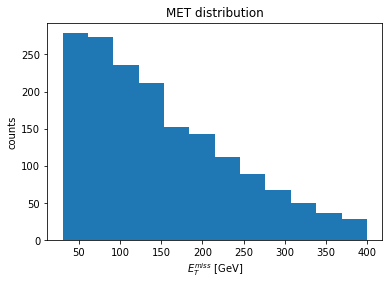

In [30]:
plt.hist(events.MET.pt, bins=12, range=[30,400], label="$E_{T}^{miss}$ [GeV]")
plt.xlabel("$E_{T}^{miss}$ [GeV]")
plt.ylabel("counts")
plt.title("MET distribution")

Text(0.5, 1.0, 'electron $p_{T}$ distribution')

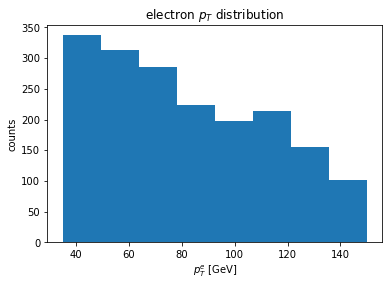

In [31]:
plt.hist(events.Electron[:,0].pt, bins=8, range=[35,150], label="$p_{T}^{e}$ [GeV]")
#previous line: you have to flatten the awkward array because its size is ambiguous due to variable-length arrays
plt.xlabel("$p_{T}^{e}$ [GeV]")
plt.ylabel("counts")
plt.title("electron $p_{T}$ distribution")

Text(0.5, 1.0, 'AK8 jet distribution')

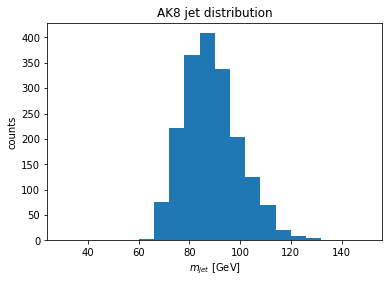

In [32]:
plt.hist(ak.flatten(events.FatJet.mass), bins=20, range=[30,150], label="$p_{T}^{e}$ [GeV]")
#previous line: you have to flatten the awkward array because its size is ambiguous due to variable-length arrays
plt.xlabel("$m_{jet}$ [GeV]")
plt.ylabel("counts")
plt.title("AK8 jet distribution")

Text(0.5, 1.0, 'VBS $m_{jj}$ distribution')

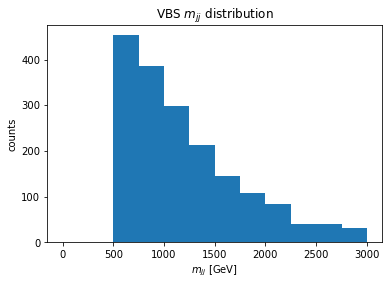

In [33]:
#VBS jets (looking for the max invariant mass pair)
# Get all combinations of jet pairs in every event
VBSjets = ak.combinations(events.Jet, 2, fields=['i0', 'i1'])
# Mask the dijets with the ismax to get dijets with the gratest mass
VBS_jets = VBSjets[(VBSjets['i0']+VBSjets['i1']).mass==ak.max((VBSjets['i0']+VBSjets['i1']).mass, axis=1)]
# Separate pairs into arrays of the leading and the trailing VBS jets in each pair.
VBS_jet_lead, VBS_jet_trail = ak.unzip(VBS_jets)
plt.hist(ak.flatten((VBS_jet_lead+VBS_jet_trail).mass), bins=12, range=[0,3000], label="$m^{jj}$ [GeV]")
plt.xlabel("$m_{jj}$ [GeV]")
plt.ylabel("counts")
plt.title("VBS $m_{jj}$ distribution")
#plt.legend()

Text(0.5, 1.0, '$\\Delta\\eta$ VBS jets')

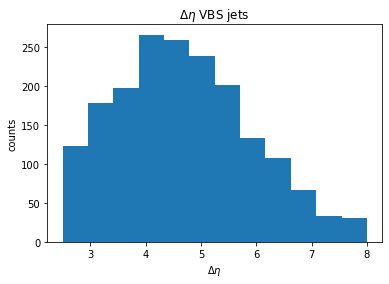

In [34]:
VBS_jet_lead, VBS_jet_trail = ak.unzip(VBS_jets)
plt.hist(ak.flatten(abs(VBS_jet_lead.eta-VBS_jet_trail.eta)), bins=12, range=[2.5,8], label="$m^{jj}$ [GeV]")
plt.xlabel("$\Delta\eta$")
plt.ylabel("counts")
plt.title("$\Delta\eta$ VBS jets")

Text(0.5, 1.0, 'Leading VBS jet $p_{t}$')

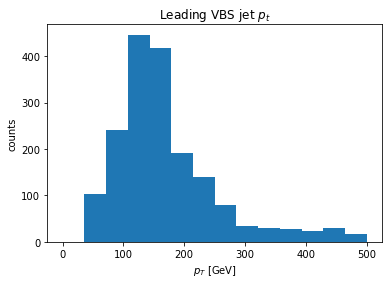

In [35]:
plt.hist(ak.flatten(VBS_jet_lead.pt), bins=14, range=[0,500], label="$p^{j}$ [GeV]")
plt.xlabel("$p_{T}$ [GeV]")
plt.ylabel("counts")
plt.title("Leading VBS jet $p_{t}$")

Text(0.5, 1.0, 'Trailing VBS jet $p_{t}$')

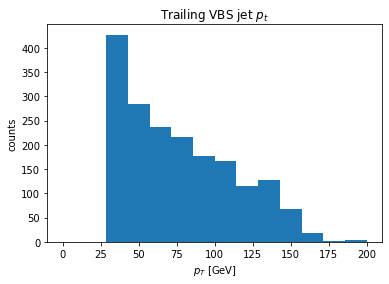

In [36]:
plt.hist(ak.flatten(VBS_jet_trail.pt), bins=14, range=[0,200], label="$p^{j}$ [GeV]")
plt.xlabel("$p_{T}$ [GeV]")
plt.ylabel("counts")
plt.title("Trailing VBS jet $p_{t}$")

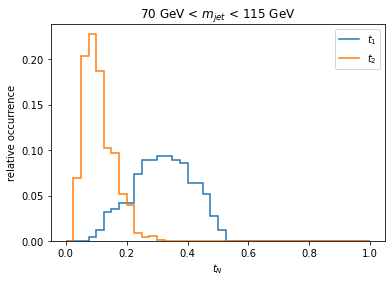

In [36]:
#Get the variables of N-subjectiness
tau_1=events.FatJet.tau1
tau_2=events.FatJet.tau2
#Normalization factors
norm_1 = ak.sum(ak.num(tau_1))
norm_2 = ak.sum(ak.num(tau_2))

#Plot two histograms together
h = hist.Hist(hist.axis.StrCategory(name='channel', label='Channel', categories=['$t_{1}$', '$t_{2}$']), 
                      hist.axis.Regular(name='t', label='tau', bins=40, start= 0, stop=1))

h.fill(channel='$t_{1}$', t=ak.flatten(tau_1), weight=1/norm_1)
h.fill(channel='$t_{2}$', t=ak.flatten(tau_2), weight=1/norm_2)
h.plot()
plt.title("70 GeV < $m_{jet}$ < 115 GeV")
plt.xlabel("$t_{N}$")
plt.ylabel("relative occurrence")
plt.legend()

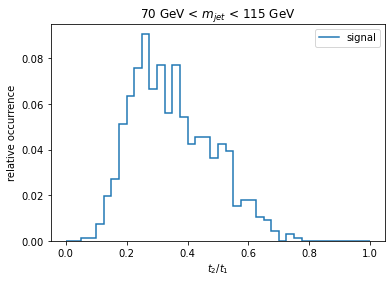

In [37]:
#Take the tau2 to tau1 ratio
tau_r=tau_2/tau_1
#Normalization factor
norm_r = ak.sum(ak.num(tau_r))
#Plot the histogram
h_r = hist.Hist(hist.axis.StrCategory(name='channel', label='Channel', categories=['signal']), 
                      hist.axis.Regular(name='t_r', label='tau', bins=40, start= 0, stop=1))
h_r.fill(channel='signal', t_r=ak.flatten(tau_r), weight=1/norm_r)

h_r.plot()
plt.title("70 GeV < $m_{jet}$ < 115 GeV")
plt.xlabel("$t_{2}/t_{1}$")
plt.ylabel("relative occurrence")
plt.legend()

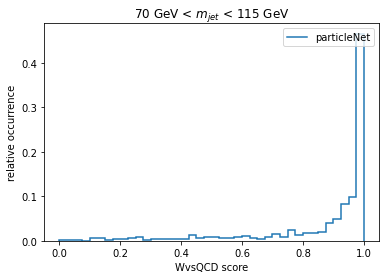

In [38]:
#Get the variables of particleNet and deepTag
pNet=events.FatJet.particleNet_WvsQCD
dTag=events.FatJet.deepTag_WvsQCD
#Normalization factor
norm_pNet = ak.sum(ak.num(pNet))
norm_dTag = ak.sum(ak.num(dTag))

#Plot two histograms together
h = hist.Hist(hist.axis.StrCategory(name='channel', label='Channel', categories=['particleNet']), 
                      hist.axis.Regular(name='WvsQCD', label='WvsQCD', bins=40, start= 0, stop=1))

h.fill(channel='particleNet', WvsQCD=ak.flatten(pNet), weight=1/norm_pNet)
h.plot()
plt.title("70 GeV < $m_{jet}$ < 115 GeV")
plt.xlabel("WvsQCD score")
plt.ylabel("relative occurrence")
plt.legend()